In [2]:
from gwpy.timeseries import TimeSeries

In [3]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

In [4]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1167557889-4096.hdf5' # data file
tevent = 1167559936.6 # UTC 2017-01-04 10:11
evtname = 'GW170104' # event name

detector = 'H1' # detecotr: L1 or H1

In [5]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

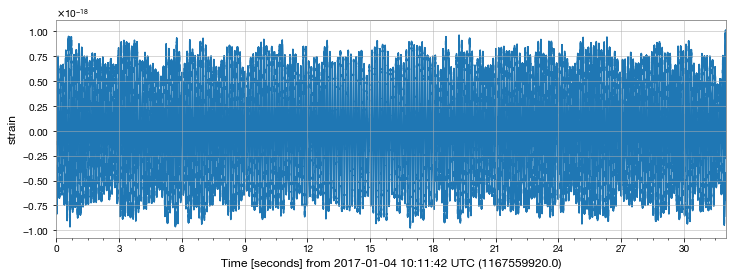

In [6]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

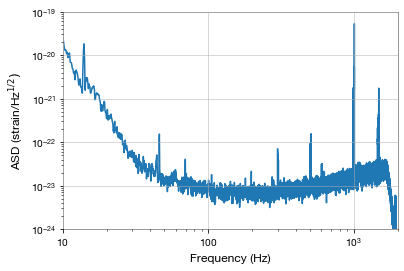

In [7]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

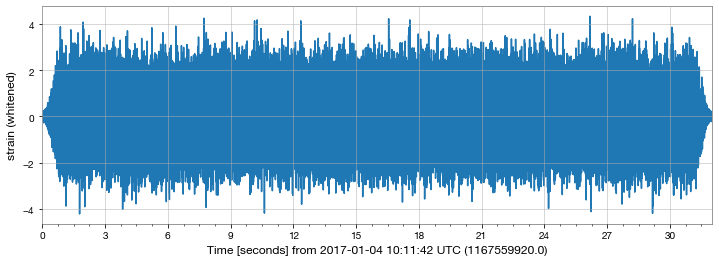

In [8]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

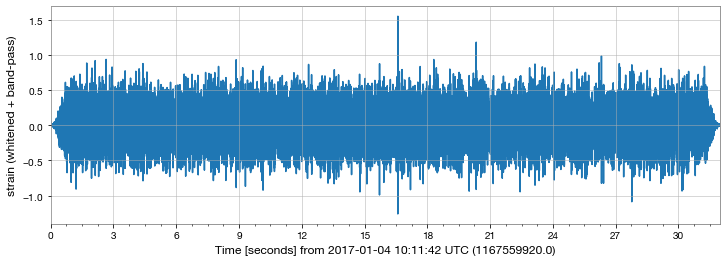

In [24]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

bandpass_low = 60
bandpass_high = 240

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

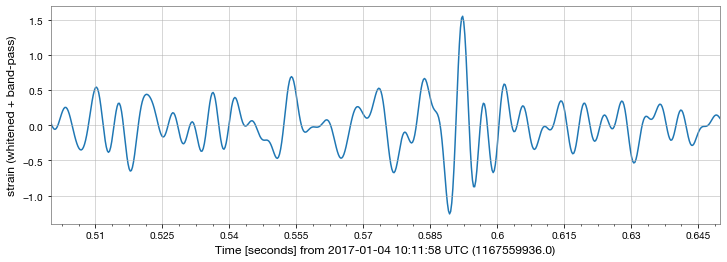

In [25]:
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.10, tevent+0.05)
plt.show()

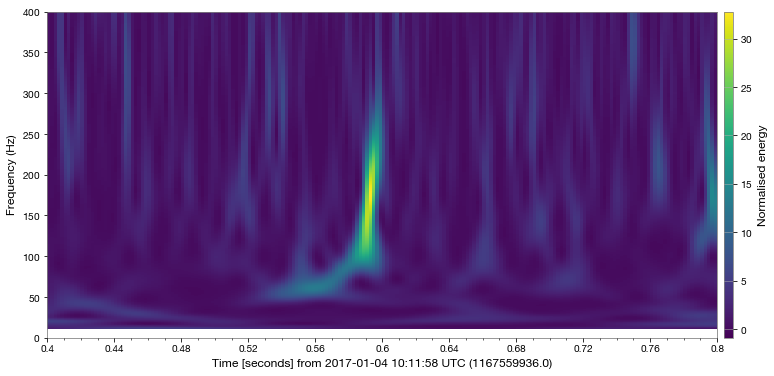

In [93]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.2, tevent+0.2)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

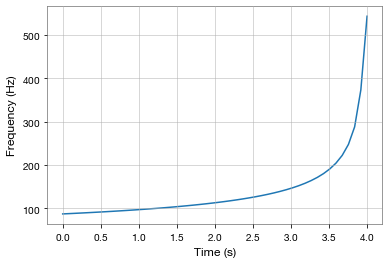

In [15]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0,cutoff=3e-2):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),cutoff),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [16]:
import lmfit

In [17]:
def osc(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0), 10/3) * np.cos(gwfreq(Mc, t, t0) * (t0-t) + phi) * np.power(1e-40, np.heaviside(t - t0, 0) * (t - t0))

In [34]:
def osc_post(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0, 10**(-2.9)), 10/3) * np.cos(gwfreq(Mc, t, t0, 10**(-2.9)) * (t0-t) + phi) * np.power(1e-90, np.heaviside(t - t0, 0) * (t - t0))

In [18]:
def osc_refine(t, Mc, t0, C, phi, cutoff, taper):
    wavepre = 10**C * np.power(Mc/2. * gwfreq(Mc/2., t, t0, 10**cutoff/1.5), 10/3) * np.cos(gwfreq(Mc/2., t, t0, 10**cutoff/1.5) * (t0-t) + phi)
    wavepost = 10**C * np.power(Mc * gwfreq(Mc, t, t0, 10**cutoff), 10/3) * np.cos(gwfreq(Mc, t, t0, 10**cutoff) * (t0-t) + phi) * np.power(10**taper, t - t0)
    return wavepre * np.heaviside(t0 - t, 0) + wavepost * np.heaviside(t - t0, 0)


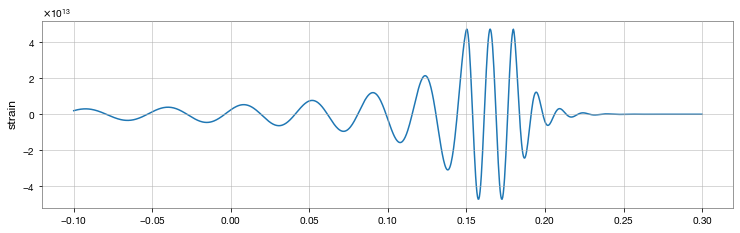

In [19]:
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
#plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()


In [41]:
def osc_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

def osc_post_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc_post(x, iM, iT0, norm, phi)
    return (val-data)/eps

def osc_ref_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    cutoff=params['cutoff']
    taper=params['taper']
    val=osc_refine(x, iM, iT0, norm, phi, cutoff, taper)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 615
    # variables        = 4
    chi-square         = 0.14098128
    reduced chi-square = 2.3074e-04
    Akaike info crit   = -5146.16153
    Bayesian info crit = -5128.47504
[[Variables]]
    Mc:   15.8014720 +/- 0.31779861 (2.01%) (init = 30)
    t0:   0.10235622 +/- 9.2456e-04 (0.90%) (init = 0.1)
    C:    1.8026e-14 +/- 1.4437e-15 (8.01%) (init = 1e-10)
    phi: -5.84181588 +/- 0.64037991 (10.96%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.981
    C(Mc, phi) =  0.887
    C(Mc, t0)  = -0.814
    C(Mc, C)   = -0.266
    C(C, phi)  = -0.221
    C(t0, C)   =  0.199


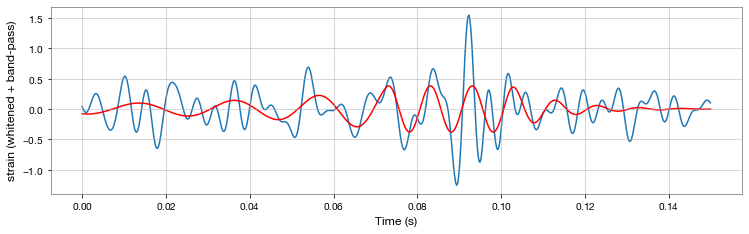

In [26]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.1)) & (sample_times < (tevent+0.05)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(30)     # Mass guess
p['t0'].set(0.1)  # By construction we put the merger in the center
p['C'].set(1e-10)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

<Figure size 432x288 with 0 Axes>

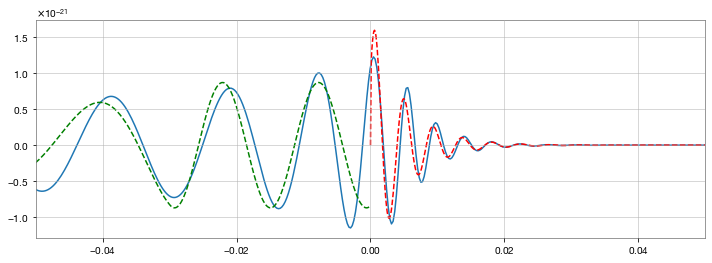

In [30]:
# load templates to get better fit for signal
NRtime, NR_H1 = np.genfromtxt('data/GW150914_4_NR_waveform.txt').transpose()
plt.clf()
plt.figure(figsize=(12, 4))
plt.plot(NRtime, NR_H1)

times = np.linspace(-0.2, 0, 1000)
freq = osc(times, 28.2, 0, 10**-34.7, -3.4)
plt.plot(times, freq, 'g--')

times = np.linspace(0, 0.1, 1000)
freq = osc_refine(times, 28.2, 0, -36.1, 1, -2.9, -90)
plt.plot(times, freq, 'r--')
plt.xlim(-0.05, 0.05)
# plt.ylim(-1e-20, 1e-20)
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 246
    # variables        = 4
    chi-square         = 0.03454682
    reduced chi-square = 1.4276e-04
    Akaike info crit   = -2174.20972
    Bayesian info crit = -2160.18839
[[Variables]]
    Mc:   35.7384369 +/- 1.01129308 (2.83%) (init = 30)
    t0:  -0.00912351 +/- 1202.81177 (13183652.66%) (init = -0.01)
    C:   -4.2678e-15 +/- 1.0638e-09 (24926177.92%) (init = 1)
    phi: -1.87884645 +/- 1492881.42 (79457340.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -1.000
    C(t0, C)   =  1.000
    C(C, phi)  = -1.000
    C(Mc, phi) = -0.236
    C(Mc, C)   =  0.236
    C(Mc, t0)  =  0.236
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 256
    # data points      = 409
    # variables        = 4
    chi-square         = 0.07737080
    reduced chi-square = 1.9104e-04
    Akaike info crit   = -3498.30012
    Bayesian 

<Figure size 432x288 with 0 Axes>

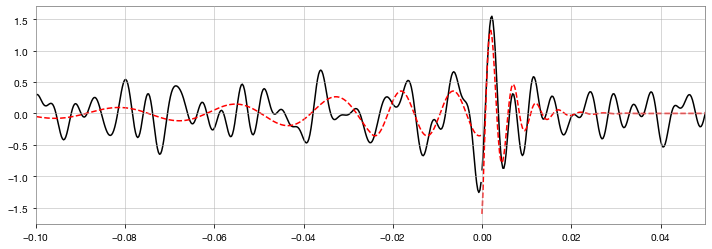

In [58]:
#NRtime, NR_H1 = np.genfromtxt('data/GW150914_4_NR_waveform.txt').transpose()
plt.clf()
plt.figure(figsize=(12, 4))
#plt.plot(NRtime, NR_H1)
plt.xlim(-0.1, 0.05)

indxtpost = np.where((sample_times >= (tevent-0.01)) & (sample_times < (tevent+0.05)))
xpost = sample_times[indxtpost]
xpt = xpost[0]
xpost = xpost-xpt
white_data_bp_zoom_post = sample_data[indxtpost]
plt.plot(xpost, white_data_bp_zoom_post, 'k')

indxtpre = np.where((sample_times >= (tevent-0.11)) & (sample_times < (tevent-0.01)))
xpre = sample_times[indxtpre]
xpre = xpre-xpt
white_data_bp_zoom_pre = sample_data[indxtpre]
plt.plot(xpre, white_data_bp_zoom_pre, 'k')

model = lmfit.Model(osc_post)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(-0.01)  
p['C'].set(1)
p['phi'].set(1)
out = minimize(osc_post_dif, params=p, args=(xpost, white_data_bp_zoom_post, np.full(len(white_data_bp_zoom_post),20)))
print(fit_report(out))
plt.plot(xpost, model.eval(params=out.params,t=xpost),'r--',label='best fit')

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(-0.01)  
p['C'].set(1)
p['phi'].set(1)
out = minimize(osc_dif, params=p, args=(xpre, white_data_bp_zoom_pre, np.full(len(white_data_bp_zoom_pre),20)))
print(fit_report(out))
plt.plot(xpre, model.eval(params=out.params,t=xpre),'r--',label='best fit')
plt.show()

In [ ]:
# write script to search for signal in large time block

## Other things to try
- Check and quantify the consistence between detectors (H1 and V1)
- Load the template database, fit the data, and get more accurate parameters
- Determine how far the source of GW is away
- Explore more events
- Data of other events can be found at https://www.gw-openscience.org/eventapi/html/allevents/
- How to determine if the source is black hole merger or neutron star merger or other source?